#### Visualize the saved dataset for quality control

In [1]:
import sys
import numpy as np
import tensorflow.compat.v1 as tf
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


##### Set the path to directory containing GANSim code of this case, since a dataset.py will be loaded

In [6]:
new_path = r'/home/users/suihong/11-GenerativeGeomodelling_GANs_MPS_Comparison/2DPointBar/2_GANSimTraining/' 
sys.path.append(new_path)

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [7]:
data_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/PreparedDataset/'

### 1. Visualize test dataset with original resolutions

*if tfrecord_dir='TestData', then test dataset will be loaded; if tfrecord_dir = 'TrainingData', then training dataset will be loaded*

In [8]:
tf.InteractiveSession()

import dataset


test_set = dataset.load_dataset(data_dir=data_dir, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# Note: labels are from -1 to 1
test_dict = test_set.get_minibatch_np(minibatch_size = 1785, lod = 0)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']

print("Facies images shape:", facies_test.shape)
print("Labels shape:", labels_test.shape)
print("Probability maps shape:", probimgs_test.shape)
print("Well facies shape:", wellfaciesimgs_test.shape)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
Facies images shape: (1785, 1, 64, 64)
Labels shape: (1785, 2)
Probability maps shape: (1785, 3, 64, 64)
Well facies shape: (1785, 1, 64, 64)


#### Denormalize global features (point bar to channel fill ratio and floodplain proportion)

In [9]:
# Extract normalized point bar to channel fill ratio and denormalize it
pb_cf_ratio = labels_test[:, 0]  # Normalized to ~[-1, 1]
pb_cf_ratio = (pb_cf_ratio / 2 + 0.5) * (2.0 - 0.2) + 0.2  # Denormalize back to original range ~[0.2, 2.0]

# Extract normalized floodplain proportion and denormalize it
fp_prop = labels_test[:, 1]  # Normalized to ~[-1, 1]
fp_prop = (fp_prop / 2 + 0.5) * (0.82 - 0.5) + 0.5  # Denormalize back to original range ~[0.5, 0.82]


#### Display obtained dataset

In [10]:
### Enlarge areas of well points only for better display ###

def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,3,3], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

wellfacies_onechannel = enlarge(wellfaciesimgs_test)
wellfacies_onechannel_mask = np.ma.masked_where(wellfacies_onechannel == 0, wellfacies_onechannel)
cmap_well = plt.cm.viridis  
cmap_well.set_bad(color='white')

In [11]:
facies_test.shape

(1785, 1, 64, 64)

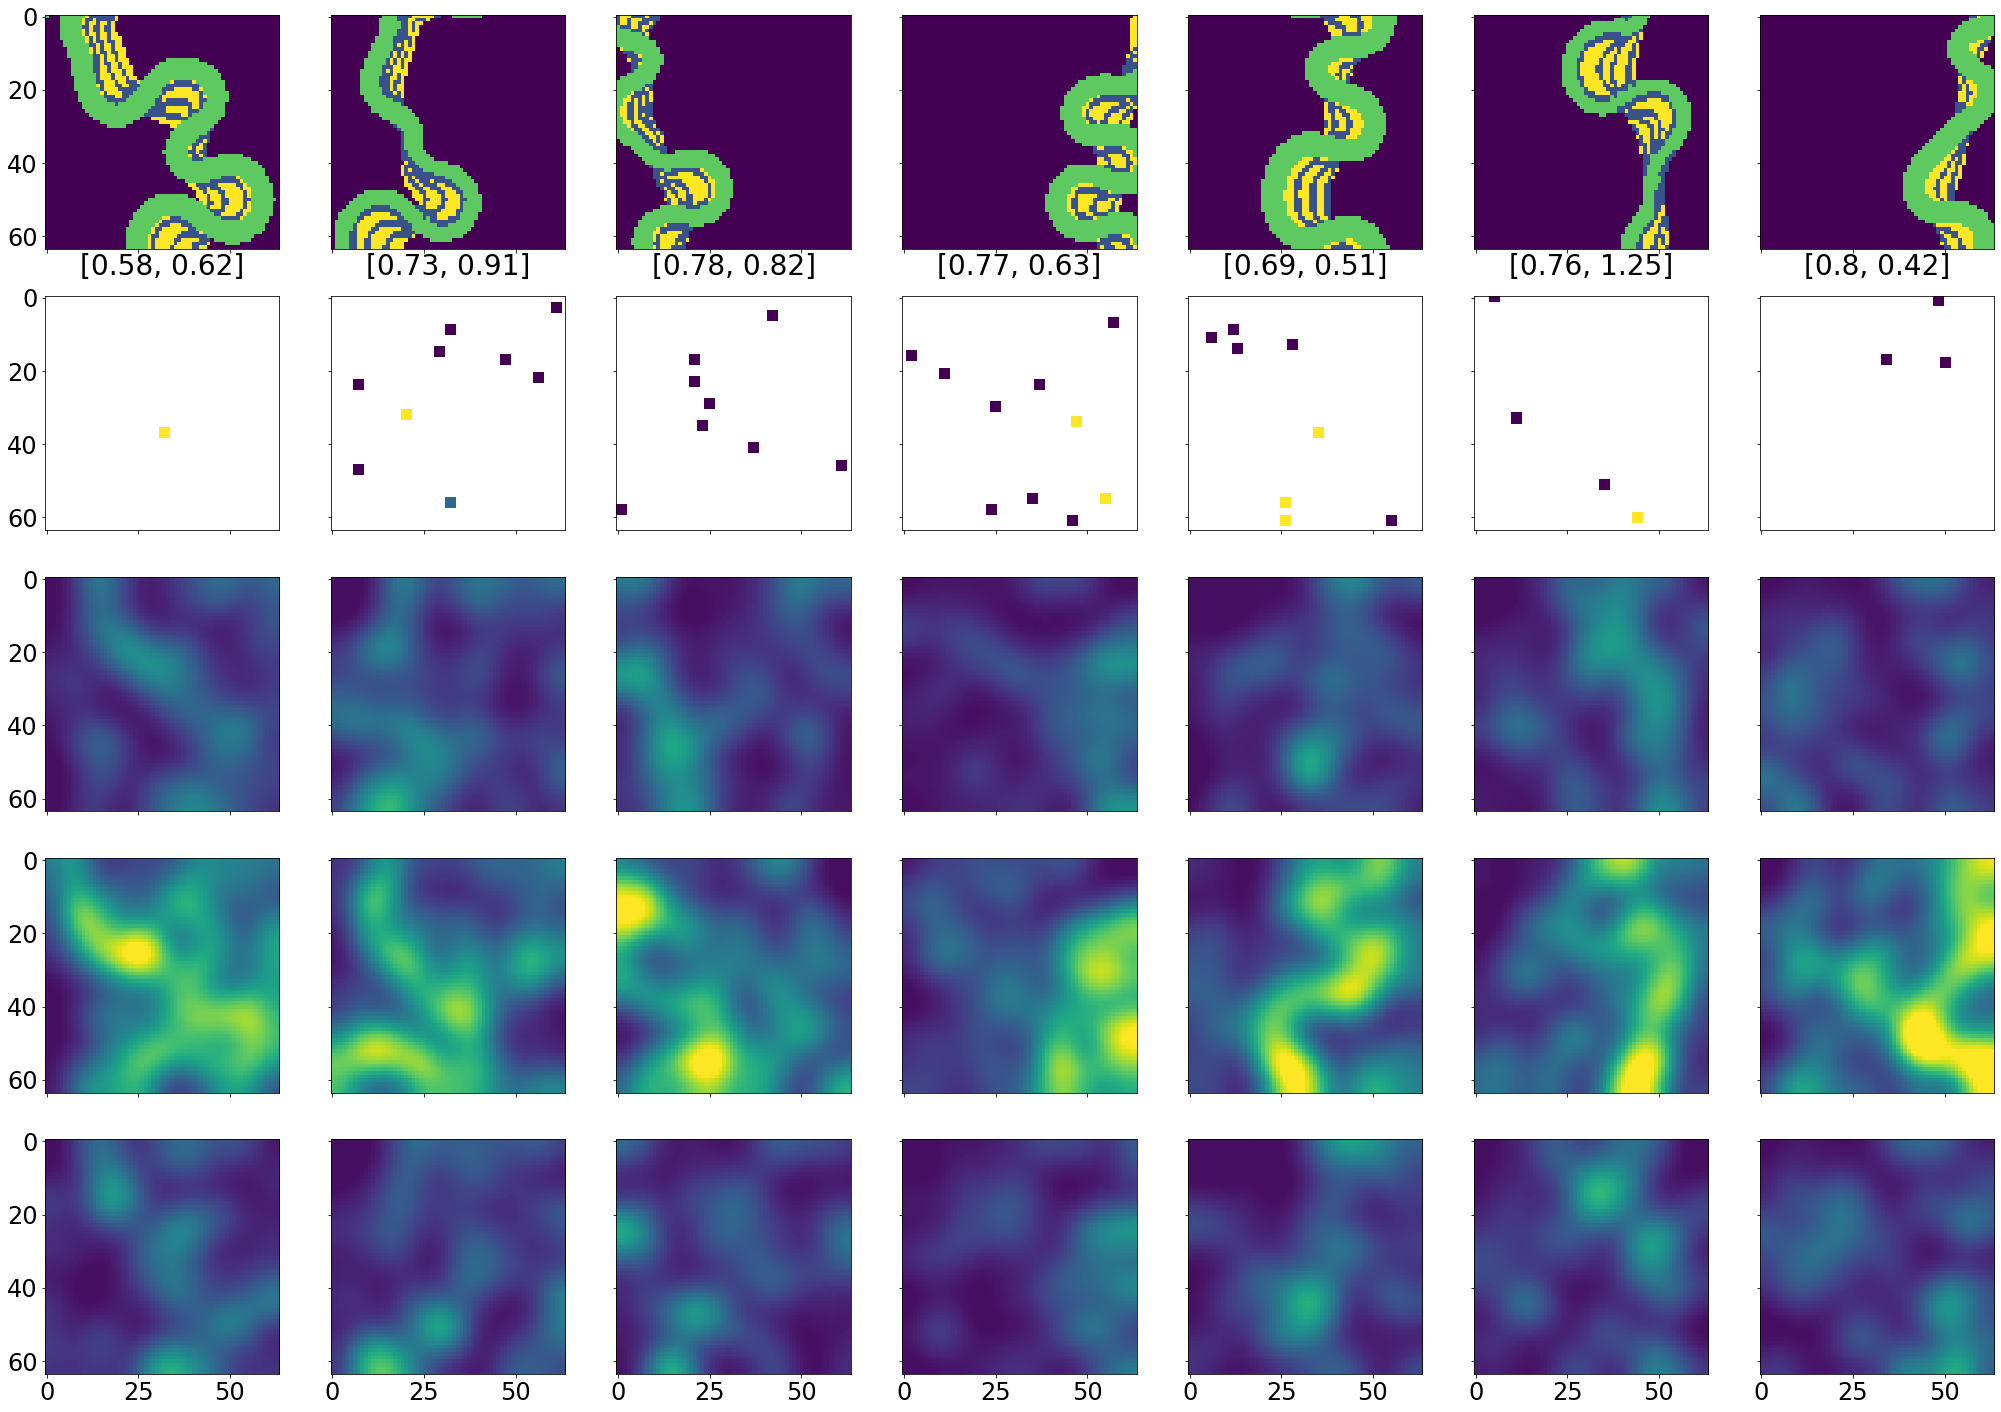

In [12]:
# Well facies data and probability maps
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(5, 7, sharex='col', sharey='row')
fig.set_size_inches(35, 25, forward=True)

for i in range(1, 8):
    ax[0, i-1].imshow(facies_test[i,0])
    ax[0, i-1].set_xlabel(f'[{str(round(fp_prop[i], 2))}, {str(round(pb_cf_ratio[i], 2))}]', fontsize=28) 
for i in range(1, 8):
    ax[1, i-1].imshow(wellfacies_onechannel_mask[i,0], cmap=cmap_well, vmin = 1, vmax = 4)  
for i in range(1, 8):
    ax[2, i-1].imshow(probimgs_test[i, 0].astype(np.float32), vmin = 0, vmax = 0.5)   
for i in range(1, 8):
    ax[3, i-1].imshow(probimgs_test[i, 1].astype(np.float32), vmin = 0, vmax = 0.5)  
for i in range(1, 8):
    ax[4, i-1].imshow(probimgs_test[i, 2].astype(np.float32), vmin = 0, vmax = 0.5)  

#plt.savefig(data_dir + "Training_data_examples.png", dpi=200) 

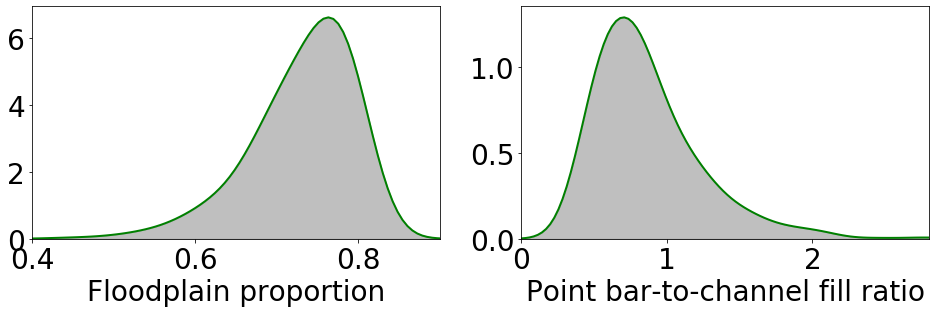

In [13]:
plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 5)

from scipy.stats import gaussian_kde
x_range = np.linspace(0.4, 1., 100)  # Generate range of values for x-axis
kde = gaussian_kde(fp_prop, bw_method=0.5)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[0].plot(x_range, pdf_values, 'g', linewidth=2, label='floodplain proportion')  # Plot PDF for mudprop
ax[0].fill_between(x_range, pdf_values, color='gray', alpha=0.5)  # Fill the area under the curve
ax[0].set_ylim(bottom=0)
ax[0].set_xlim(left=0.4, right = 0.9)
ax[0].set_xlabel('Floodplain proportion')

x_range = np.linspace(0, 2.8, 100)  # Generate range of values for x-axis
kde = gaussian_kde(pb_cf_ratio, bw_method=0.35)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[1].plot(x_range, pdf_values, 'g', linewidth=2, label='Point bar-to-channel fill ratio')  # Plot PDF for mudprop
ax[1].fill_between(x_range, pdf_values, color='gray', alpha=0.5)  # Fill the area under the curve
ax[1].set_ylim(bottom=0)
ax[1].set_xlim(left=0., right = 2.8)
ax[1].set_xlabel('Point bar-to-channel fill ratio')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.25)

# Use tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the figure
#plt.savefig(data_dir + "GlobalFeatureHistograms.png", dpi=100) 

### 2. Visualize test dataset with coarser resolutions (16x16)

*if tfrecord_dir='TestData', then test dataset will be loaded; if tfrecord_dir = 'TrainingData', then training dataset will be loaded*

In [14]:
tf.InteractiveSession()

import dataset


test_set = dataset.load_dataset(data_dir=data_dir, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# Note: labels are from -1 to 1
test_dict = test_set.get_minibatch_np(minibatch_size = 1785, lod = 2)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']

print("Facies images shape:", facies_test.shape)
print("Labels shape:", labels_test.shape)
print("Probability maps shape:", probimgs_test.shape)
print("Well facies shape:", wellfaciesimgs_test.shape)

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
Facies images shape: (1785, 1, 16, 16)
Labels shape: (1785, 2)
Probability maps shape: (1785, 3, 64, 64)
Well facies shape: (1785, 1, 64, 64)


#### Denormalize global features (point bar to channel fill ratio and floodplain proportion)

In [15]:
# Extract normalized point bar to channel fill ratio and denormalize it
pb_cf_ratio = labels_test[:, 0]  # Normalized to ~[-1, 1]
pb_cf_ratio = (pb_cf_ratio / 2 + 0.5) * (2.0 - 0.2) + 0.2  # Denormalize back to original range ~[0.2, 2.0]

# Extract normalized floodplain proportion and denormalize it
fp_prop = labels_test[:, 1]  # Normalized to ~[-1, 1]
fp_prop = (fp_prop / 2 + 0.5) * (0.82 - 0.5) + 0.5  # Denormalize back to original range ~[0.5, 0.82]


#### Display obtained dataset

In [16]:
### Enlarge areas of well points only for better display ###

def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,3,3], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

wellfacies_onechannel = enlarge(wellfaciesimgs_test)
wellfacies_onechannel_mask = np.ma.masked_where(wellfacies_onechannel == 0, wellfacies_onechannel)
cmap_well = plt.cm.viridis  
cmap_well.set_bad(color='white')

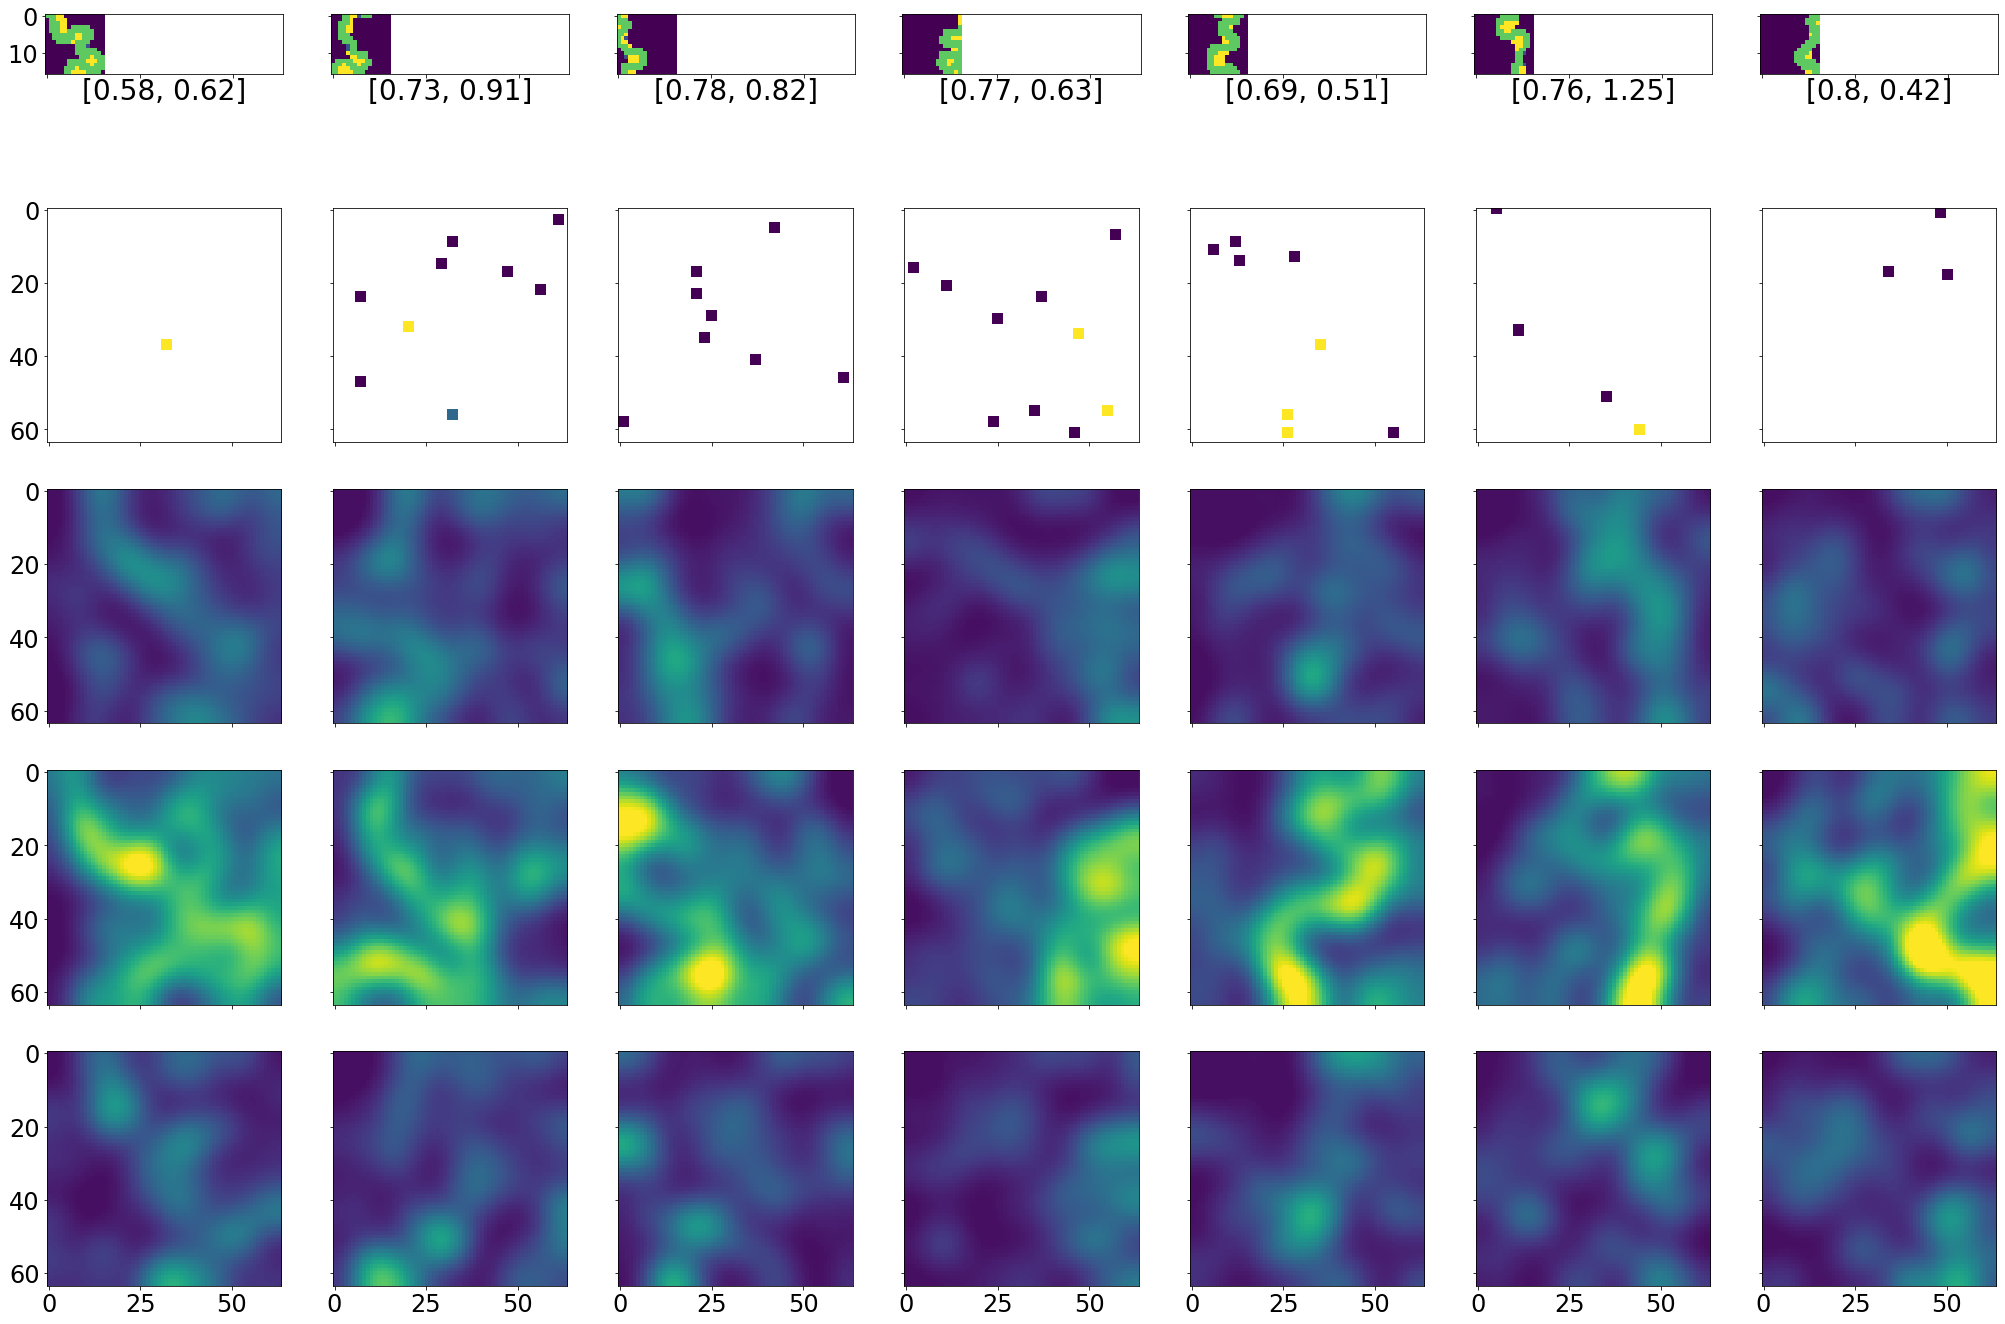

In [17]:
# Well facies data and probability maps
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(5, 7, sharex='col', sharey='row')
fig.set_size_inches(35, 25, forward=True)

for i in range(1, 8):
    ax[0, i-1].imshow(facies_test[i,0])
    ax[0, i-1].set_xlabel(f'[{str(round(fp_prop[i], 2))}, {str(round(pb_cf_ratio[i], 2))}]', fontsize=28) 
for i in range(1, 8):
    ax[1, i-1].imshow(wellfacies_onechannel_mask[i,0], cmap=cmap_well, vmin = 1, vmax = 4)  
for i in range(1, 8):
    ax[2, i-1].imshow(probimgs_test[i, 0].astype(np.float32), vmin = 0, vmax = 0.5)   
for i in range(1, 8):
    ax[3, i-1].imshow(probimgs_test[i, 1].astype(np.float32), vmin = 0, vmax = 0.5)  
for i in range(1, 8):
    ax[4, i-1].imshow(probimgs_test[i, 2].astype(np.float32), vmin = 0, vmax = 0.5)  

#plt.savefig(data_dir + "Training_data_examples.png", dpi=200) 

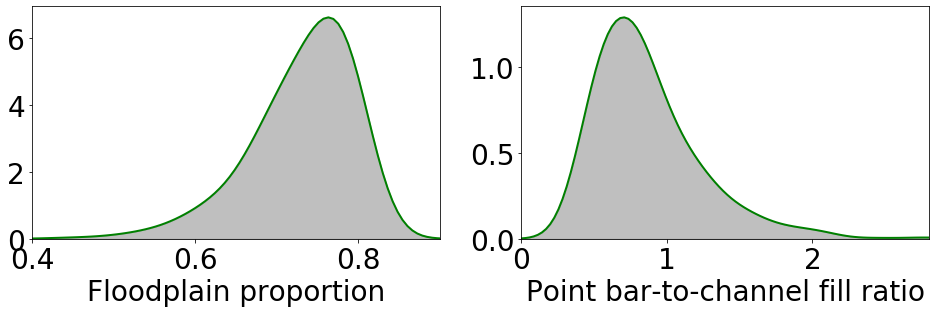

In [18]:
plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 5)

from scipy.stats import gaussian_kde
x_range = np.linspace(0.4, 1., 100)  # Generate range of values for x-axis
kde = gaussian_kde(fp_prop, bw_method=0.5)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[0].plot(x_range, pdf_values, 'g', linewidth=2, label='floodplain proportion')  # Plot PDF for mudprop
ax[0].fill_between(x_range, pdf_values, color='gray', alpha=0.5)  # Fill the area under the curve
ax[0].set_ylim(bottom=0)
ax[0].set_xlim(left=0.4, right = 0.9)
ax[0].set_xlabel('Floodplain proportion')

x_range = np.linspace(0, 2.8, 100)  # Generate range of values for x-axis
kde = gaussian_kde(pb_cf_ratio, bw_method=0.35)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[1].plot(x_range, pdf_values, 'g', linewidth=2, label='Point bar-to-channel fill ratio')  # Plot PDF for mudprop
ax[1].fill_between(x_range, pdf_values, color='gray', alpha=0.5)  # Fill the area under the curve
ax[1].set_ylim(bottom=0)
ax[1].set_xlim(left=0., right = 2.8)
ax[1].set_xlabel('Point bar-to-channel fill ratio')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.25)

# Use tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the figure
#plt.savefig(data_dir + "GlobalFeatureHistograms.png", dpi=100) 

### 3. Visualize training dataset with original resolutions

*if tfrecord_dir='TestData', then test dataset will be loaded; if tfrecord_dir = 'TrainingData', then training dataset will be loaded*

In [19]:
tf.InteractiveSession()

import dataset


test_set = dataset.load_dataset(data_dir=data_dir, verbose=True, tfrecord_dir='TrainingData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# Note: labels are from -1 to 1
test_dict = test_set.get_minibatch_np(minibatch_size = 1785, lod = 0)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']

print("Facies images shape:", facies_test.shape)
print("Labels shape:", labels_test.shape)
print("Probability maps shape:", probimgs_test.shape)
print("Well facies shape:", wellfaciesimgs_test.shape)

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
Facies images shape: (1785, 1, 64, 64)
Labels shape: (1785, 2)
Probability maps shape: (1785, 3, 64, 64)
Well facies shape: (1785, 1, 64, 64)


#### Denormalize global features (point bar to channel fill ratio and floodplain proportion)

In [20]:
# Extract normalized point bar to channel fill ratio and denormalize it
pb_cf_ratio = labels_test[:, 0]  # Normalized to ~[-1, 1]
pb_cf_ratio = (pb_cf_ratio / 2 + 0.5) * (2.0 - 0.2) + 0.2  # Denormalize back to original range ~[0.2, 2.0]

# Extract normalized floodplain proportion and denormalize it
fp_prop = labels_test[:, 1]  # Normalized to ~[-1, 1]
fp_prop = (fp_prop / 2 + 0.5) * (0.82 - 0.5) + 0.5  # Denormalize back to original range ~[0.5, 0.82]


#### Display obtained dataset

In [21]:
### Enlarge areas of well points only for better display ###

def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,3,3], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

wellfacies_onechannel = enlarge(wellfaciesimgs_test)
wellfacies_onechannel_mask = np.ma.masked_where(wellfacies_onechannel == 0, wellfacies_onechannel)
cmap_well = plt.cm.viridis  
cmap_well.set_bad(color='white')

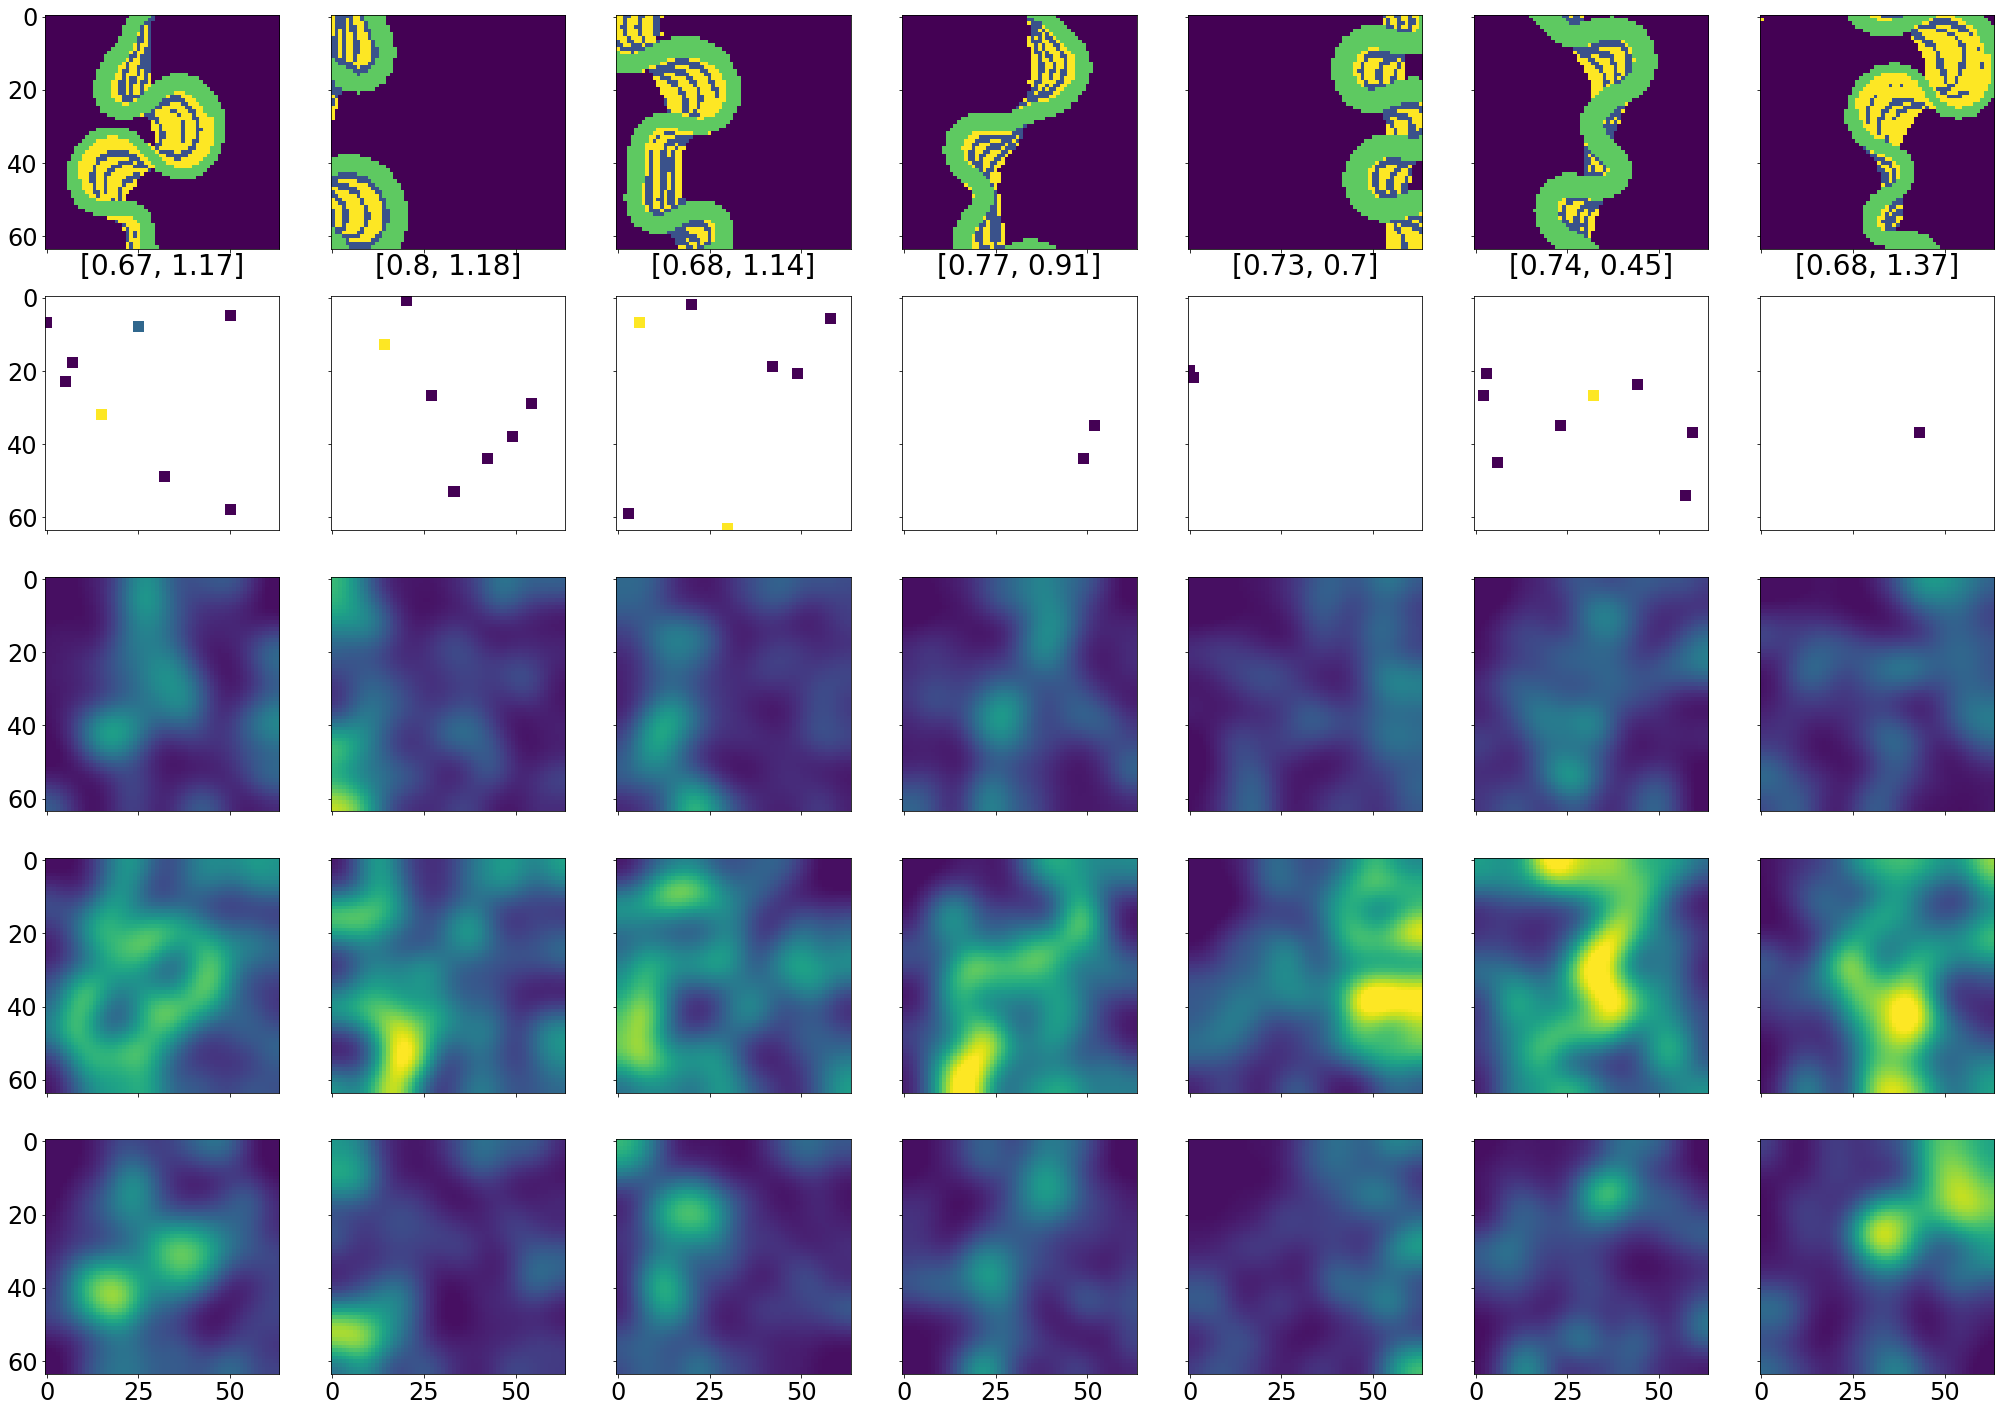

In [22]:
# Well facies data and probability maps
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(5, 7, sharex='col', sharey='row')
fig.set_size_inches(35, 25, forward=True)

for i in range(1, 8):
    ax[0, i-1].imshow(facies_test[i,0])
    ax[0, i-1].set_xlabel(f'[{str(round(fp_prop[i], 2))}, {str(round(pb_cf_ratio[i], 2))}]', fontsize=28) 
for i in range(1, 8):
    ax[1, i-1].imshow(wellfacies_onechannel_mask[i,0], cmap=cmap_well, vmin = 1, vmax = 4)  
for i in range(1, 8):
    ax[2, i-1].imshow(probimgs_test[i, 0].astype(np.float32), vmin = 0, vmax = 0.5)   
for i in range(1, 8):
    ax[3, i-1].imshow(probimgs_test[i, 1].astype(np.float32), vmin = 0, vmax = 0.5)  
for i in range(1, 8):
    ax[4, i-1].imshow(probimgs_test[i, 2].astype(np.float32), vmin = 0, vmax = 0.5)  

#plt.savefig(data_dir + "Training_data_examples.png", dpi=200) 

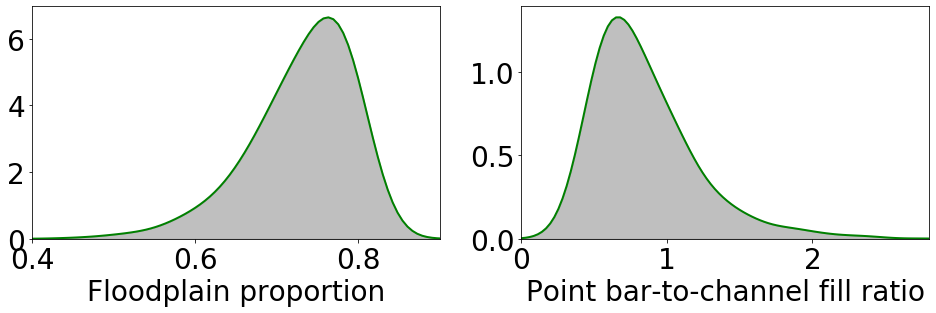

In [23]:
plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 5)

from scipy.stats import gaussian_kde
x_range = np.linspace(0.4, 1., 100)  # Generate range of values for x-axis
kde = gaussian_kde(fp_prop, bw_method=0.5)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[0].plot(x_range, pdf_values, 'g', linewidth=2, label='floodplain proportion')  # Plot PDF for mudprop
ax[0].fill_between(x_range, pdf_values, color='gray', alpha=0.5)  # Fill the area under the curve
ax[0].set_ylim(bottom=0)
ax[0].set_xlim(left=0.4, right = 0.9)
ax[0].set_xlabel('Floodplain proportion')

x_range = np.linspace(0, 2.8, 100)  # Generate range of values for x-axis
kde = gaussian_kde(pb_cf_ratio, bw_method=0.35)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[1].plot(x_range, pdf_values, 'g', linewidth=2, label='Point bar-to-channel fill ratio')  # Plot PDF for mudprop
ax[1].fill_between(x_range, pdf_values, color='gray', alpha=0.5)  # Fill the area under the curve
ax[1].set_ylim(bottom=0)
ax[1].set_xlim(left=0., right = 2.8)
ax[1].set_xlabel('Point bar-to-channel fill ratio')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.25)

# Use tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the figure
#plt.savefig(data_dir + "GlobalFeatureHistograms.png", dpi=100) 

### 4. Visualize training dataset with coarser resolutions (16x16)

*if tfrecord_dir='TestData', then test dataset will be loaded; if tfrecord_dir = 'TrainingData', then training dataset will be loaded*

In [24]:
tf.InteractiveSession()

import dataset


test_set = dataset.load_dataset(data_dir=data_dir, verbose=True, tfrecord_dir='TrainingData', 
                                 cond_label = True, cond_well = True, cond_prob = True,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# Note: labels are from -1 to 1
test_dict = test_set.get_minibatch_np(minibatch_size = 1785, lod = 2)  
facies_test = test_dict['real']
labels_test = test_dict['label']
probimgs_test = test_dict['prob']
wellfaciesimgs_test = test_dict['well']

print("Facies images shape:", facies_test.shape)
print("Labels shape:", labels_test.shape)
print("Probability maps shape:", probimgs_test.shape)
print("Well facies shape:", wellfaciesimgs_test.shape)

/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Streaming data using dataset.TFRecordDataset...
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
Facies images shape: (1785, 1, 16, 16)
Labels shape: (1785, 2)
Probability maps shape: (1785, 3, 64, 64)
Well facies shape: (1785, 1, 64, 64)


#### Denormalize global features (point bar to channel fill ratio and floodplain proportion)

In [25]:
# Extract normalized point bar to channel fill ratio and denormalize it
pb_cf_ratio = labels_test[:, 0]  # Normalized to ~[-1, 1]
pb_cf_ratio = (pb_cf_ratio / 2 + 0.5) * (2.0 - 0.2) + 0.2  # Denormalize back to original range ~[0.2, 2.0]

# Extract normalized floodplain proportion and denormalize it
fp_prop = labels_test[:, 1]  # Normalized to ~[-1, 1]
fp_prop = (fp_prop / 2 + 0.5) * (0.82 - 0.5) + 0.5  # Denormalize back to original range ~[0.5, 0.82]


#### Display obtained dataset

In [26]:
### Enlarge areas of well points only for better display ###

def enlarge(well_facies):
    ### Enlarge areas of well points into 4 x 4 as inputs
    with tf.device('/gpu:0'):
        well_facies = tf.cast(well_facies, tf.float32)
        well_facies_enlarge = tf.nn.max_pool(well_facies, ksize = [1,1,3,3], strides=[1,1,1,1], padding='SAME', data_format='NCHW') 
    with tf.Session() as sess: 
        sess.run(tf.global_variables_initializer())
        well_points_el = sess.run(well_facies_enlarge) 
    return well_points_el

wellfacies_onechannel = enlarge(wellfaciesimgs_test)
wellfacies_onechannel_mask = np.ma.masked_where(wellfacies_onechannel == 0, wellfacies_onechannel)
cmap_well = plt.cm.viridis  
cmap_well.set_bad(color='white')

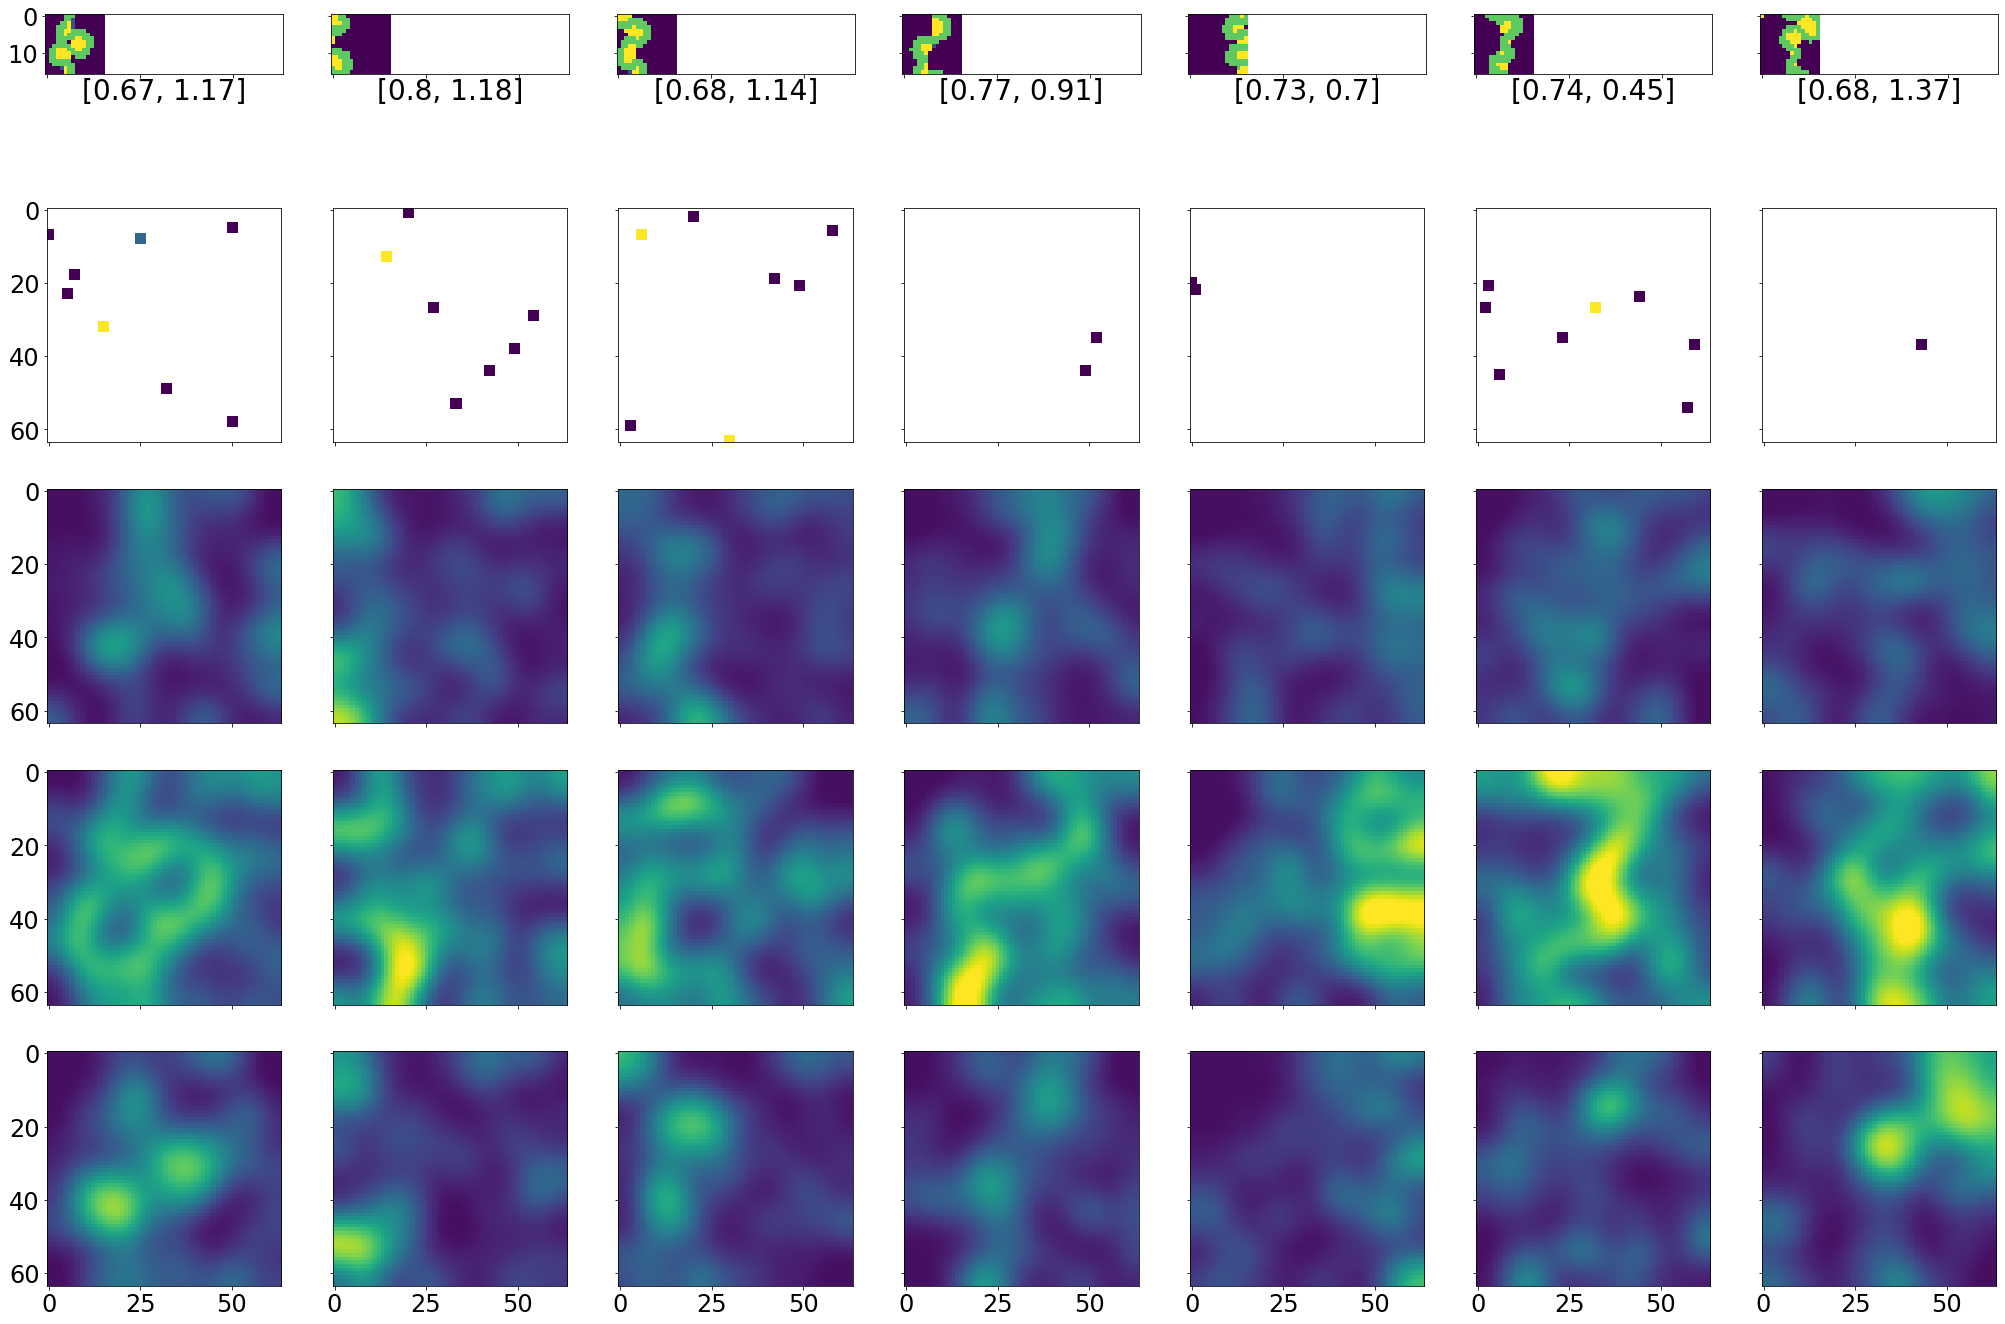

In [27]:
# Well facies data and probability maps
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(5, 7, sharex='col', sharey='row')
fig.set_size_inches(35, 25, forward=True)

for i in range(1, 8):
    ax[0, i-1].imshow(facies_test[i,0])
    ax[0, i-1].set_xlabel(f'[{str(round(fp_prop[i], 2))}, {str(round(pb_cf_ratio[i], 2))}]', fontsize=28) 
for i in range(1, 8):
    ax[1, i-1].imshow(wellfacies_onechannel_mask[i,0], cmap=cmap_well, vmin = 1, vmax = 4)  
for i in range(1, 8):
    ax[2, i-1].imshow(probimgs_test[i, 0].astype(np.float32), vmin = 0, vmax = 0.5)   
for i in range(1, 8):
    ax[3, i-1].imshow(probimgs_test[i, 1].astype(np.float32), vmin = 0, vmax = 0.5)  
for i in range(1, 8):
    ax[4, i-1].imshow(probimgs_test[i, 2].astype(np.float32), vmin = 0, vmax = 0.5)  

#plt.savefig(data_dir + "Training_data_examples.png", dpi=200) 

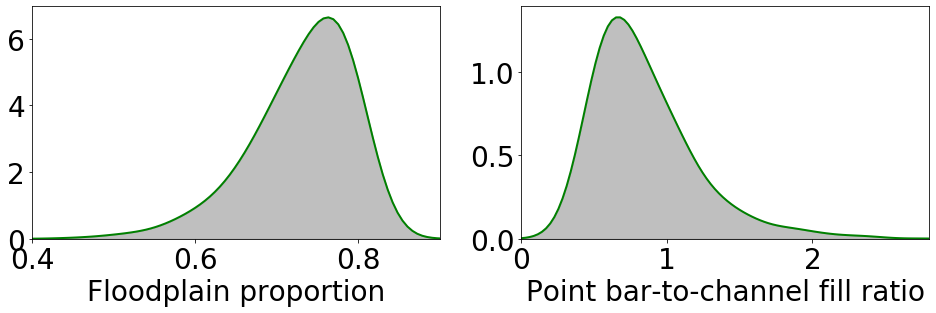

In [28]:
plt.rcParams.update({'font.size': 28})

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 5)

from scipy.stats import gaussian_kde
x_range = np.linspace(0.4, 1., 100)  # Generate range of values for x-axis
kde = gaussian_kde(fp_prop, bw_method=0.5)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[0].plot(x_range, pdf_values, 'g', linewidth=2, label='floodplain proportion')  # Plot PDF for mudprop
ax[0].fill_between(x_range, pdf_values, color='gray', alpha=0.5)  # Fill the area under the curve
ax[0].set_ylim(bottom=0)
ax[0].set_xlim(left=0.4, right = 0.9)
ax[0].set_xlabel('Floodplain proportion')

x_range = np.linspace(0, 2.8, 100)  # Generate range of values for x-axis
kde = gaussian_kde(pb_cf_ratio, bw_method=0.35)
pdf_values = kde(x_range)  # Compute PDF values for the range
# Plot the PDFs on the same axis
ax[1].plot(x_range, pdf_values, 'g', linewidth=2, label='Point bar-to-channel fill ratio')  # Plot PDF for mudprop
ax[1].fill_between(x_range, pdf_values, color='gray', alpha=0.5)  # Fill the area under the curve
ax[1].set_ylim(bottom=0)
ax[1].set_xlim(left=0., right = 2.8)
ax[1].set_xlabel('Point bar-to-channel fill ratio')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.25)

# Use tight layout to prevent labels from being cut off
plt.tight_layout()

# Save the figure
#plt.savefig(data_dir + "GlobalFeatureHistograms.png", dpi=100) 